# <center> Basic Movie Recommendation Systems
## <center> Apriori; Collaborative Filtering; Content Based; Hybrid System
    
Here in this notebook, we would like to create a recommender system based on dataset found here.
    
    Author: Tri Juliansyah Muharam Sambas; Rangga Pratama
    Date: 15th November 2019

## Outline
- TLDR; Executive Summary
- Importing Libraries
- Importing Dataset
- Exploratory Data Analysis
- Modeling
- Simulation

## TLDR; Executive Summary

## Import Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import KMeans

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori

from collections import Counter

import networkx as nx

import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/TJMSambas/movie_recommendation_netflix/master/ml-latest-small/ratings.csv')
del df['timestamp']
title = pd.read_csv('https://raw.githubusercontent.com/TJMSambas/movie_recommendation_netflix/master/ml-latest-small/movies.csv')
df = pd.merge(df,title, on = 'movieId', how = 'left')
tags = pd.read_csv('https://raw.githubusercontent.com/TJMSambas/movie_recommendation_netflix/master/ml-latest-small/tags.csv')
del tags['timestamp']
df = pd.merge(df,tags, on = ['movieId','userId'], how = 'left')

In [4]:
year = []
title = []
title_df = list(df['title'])
for i in range(len(title_df)) :
    if title_df[i][-2].isdigit() == True :
        year.append(title_df[i][-5:-1])
        title.append(title_df[i][:-6])
    else :
        year.append('NaN')
        title.append(title_df[i])
        
df['title'] = title
df['year'] = year

## Exploratory Data Analysis

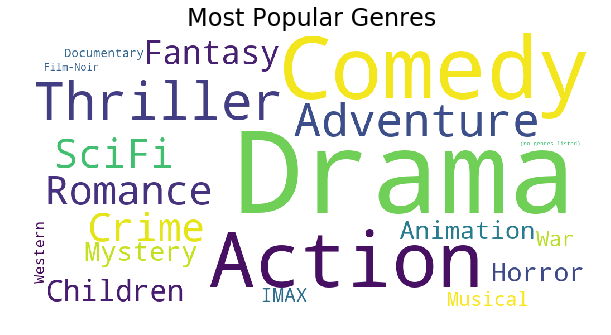

In [50]:
# creating wordcloud of the most popular genres

plt.figure(figsize = (10,10))
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 500, max_words = 100).generate_from_frequencies(Counter(','.join(df['genres'].str.replace('|',',')).replace('Sci-Fi','SciFi').split(',')))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Genres',fontsize = 24)
plt.show()

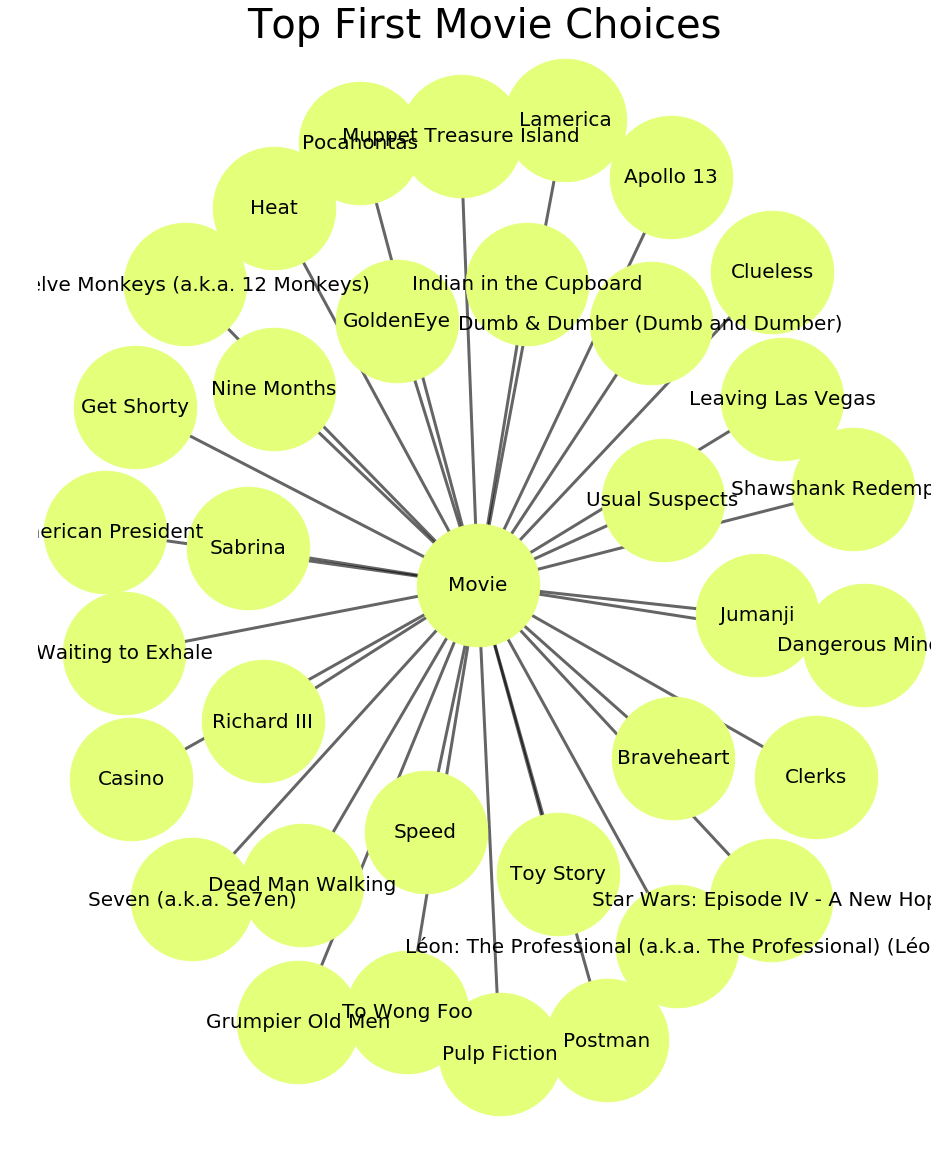

In [71]:
# listing top first movie to watch

df_nx = pd.DataFrame(df['userId'].unique()).rename(columns = {0 : 'userId'})
df['title'] = df['title'].str.rstrip()
listuser = list(df_nx['userId'])
listtitle = []
for i in range(len(listuser)) :
    title = ', '.join(df[df['userId'] == listuser[i]]['title'])
    listtitle.append(title)
df_nx['title'] = listtitle
del df_nx['userId']

df_nx = df_nx['title'].str.split(',', expand = True)

df_nx['movie'] = 'Movie'
movie = df_nx.truncate(before = -1, after = 100)

movie = nx.from_pandas_edgelist(movie, source = 'movie', target = 0, edge_attr = True)

plt.rcParams['figure.figsize'] = (16, 20)
pos = nx.spring_layout(movie)
color = plt.cm.Wistia(np.linspace(0, 5, 1))
nx.draw_networkx_nodes(movie, pos, node_size = 15000, node_color = color)
nx.draw_networkx_edges(movie, pos, width = 3, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(movie, pos, font_size = 20, font_family = 'sans-serif')
plt.axis('off')
plt.grid()
plt.title('Top First Movie Choices', fontsize = 40)
plt.show()

Text(0.5, 1.0, 'Minimum Support 0.3')

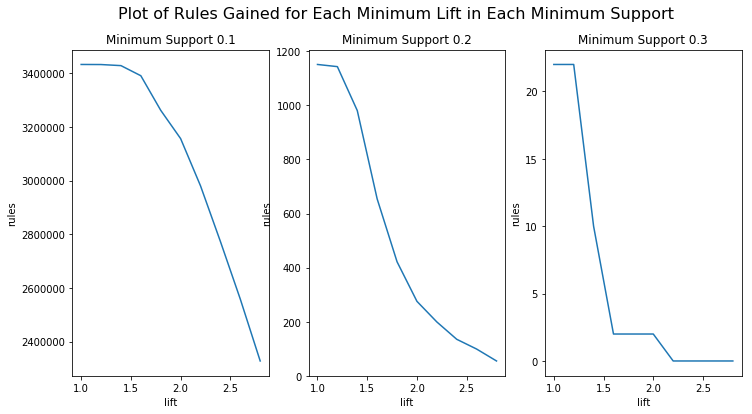

In [109]:
# plotting rules gained for each minimum lift and each minimum support to find the most optimal point

movielist = []
for i in df['userId'].unique() :
    mlist = list(set(df[df['userId'] == i]['title']))
    if len(mlist) > 0 :
        movielist.append(mlist)

te = TransactionEncoder()
te_ary = te.fit(movielist).transform(movielist)
df_apriori = pd.DataFrame(te_ary, columns = te.columns_)

list_supp = [0.1,0.2,0.3]
list_lift = [1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8]
rules_each_lift = []
for i in list_supp : 
    frequent_moviesets = apriori(df_apriori, min_support = i)
    for j in list_lift :
        rules = association_rules(frequent_moviesets, metric = 'lift', min_threshold = j)
        rules_each_lift.append(len(rules))

rules_each_lift = [rules_each_lift[i:i + 10] for i in range(0, len(rules_each_lift), 10)]
rules_a = rules_each_lift[0]
rules_b = rules_each_lift[1]
rules_c = rules_each_lift[2]

plt.figure(figsize = (12,6))
plt.suptitle('Plot of Rules Gained for Each Minimum Lift in Each Minimum Support', size = 16)

plt.subplot(1,3,1)
a = sns.lineplot(x=list_lift, y = rules_a)
plt.xlabel('lift')
plt.ylabel('rules')
plt.title('Minimum Support 0.1')

plt.subplot(1,3,2)
b = sns.lineplot(x=list_lift, y = rules_b)
plt.xlabel('lift')
plt.ylabel('rules')
plt.title('Minimum Support 0.2')

plt.subplot(1,3,3)
c = sns.lineplot(x=list_lift, y = rules_c)
plt.xlabel('lift')
plt.ylabel('rules')
plt.title('Minimum Support 0.3')

## Modeling

### Apriori

In [190]:
# from the EDA above, we choose min_support = 0.1 and min_threshold 1.6 as the optimal point

frequent_moviesets = apriori(df_apriori, min_support = 0.1, use_colnames = True)
rules = association_rules(frequent_moviesets, metric = 'lift', min_threshold = 1.6)
rules.sort_values('confidence', ascending = False) 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
968743,"(Die Hard , Godfather, The , Forrest Gump , St...",(Star Wars: Episode IV - A New Hope ),0.108197,0.411475,0.108197,1.00000,2.430279,0.063676,inf
1927504,"(Forrest Gump , Star Wars: Episode V - The Emp...",(Star Wars: Episode VI - Return of the Jedi ),0.103279,0.321311,0.103279,1.00000,3.112245,0.070094,inf
2368320,"(Forrest Gump , Men in Black (a.k.a. MIB) , St...",(Star Wars: Episode V - The Empire Strikes Back ),0.104918,0.345902,0.104918,1.00000,2.890995,0.068627,inf
2368318,"(Forrest Gump , Star Wars: Episode V - The Emp...",(Star Wars: Episode IV - A New Hope ),0.104918,0.411475,0.104918,1.00000,2.430279,0.061747,inf
2641398,"(Pulp Fiction , Toy Story , Matrix, The , Term...",(Star Wars: Episode V - The Empire Strikes Back ),0.100000,0.345902,0.100000,1.00000,2.890995,0.065410,inf
...,...,...,...,...,...,...,...,...,...
2686739,(Forrest Gump ),"(Jurassic Park , Pulp Fiction , Star Wars: Epi...",0.539344,0.109836,0.100000,0.18541,1.688064,0.040761,1.092776
1322912,(Forrest Gump ),"(True Lies , Mission: Impossible , Terminator ...",0.539344,0.114754,0.100000,0.18541,1.615719,0.038108,1.086738
917468,(Forrest Gump ),"(Silence of the Lambs, The , Jurassic Park , B...",0.539344,0.114754,0.100000,0.18541,1.615719,0.038108,1.086738
2337648,(Forrest Gump ),"(Pulp Fiction , Lord of the Rings: The Two Tow...",0.539344,0.106557,0.100000,0.18541,1.740005,0.042529,1.096801


## Simulation

### Simulation of Recommendation by Apriori Algorithm

In [205]:
# creating "basket" of movies given a movie title (so we can recommend another movies to watch after a certain movie)

watched = 'Toy Story '   # INPUT THE TITLE AND GIVE SPACE IN THE END

dum = rules[rules['consequents'] == frozenset({watched})].sort_values(by = 'lift', ascending = False).head(5)
dum['len'] = len(dum['antecedents'])

for x in dum.sort_values(by = 'len').head(1)['antecedents'].apply(lambda x : list(x)).astype('unicode') :
    print(x)

['Jurassic Park ', 'Pulp Fiction ', 'Indiana Jones and the Last Crusade ', 'Back to the Future ', 'Star Wars: Episode IV - A New Hope ']


So after a person watch Toy Story, based on the apriori algorithm, it's better to recommend him Jurassic Park, Pulp Fiction, Indiana Jones and the Last Crusade, Back to the Future, Star Wars : Episode IV - A New Hope

In [207]:
# preparing data for content based

movie_data = pd.read_csv('D:/Titip/movie_metadata.csv')

movie_data.drop(['director_name','actor_2_name','genres','actor_1_name','actor_3_name','movie_imdb_link','title_year','plot_keywords'], axis = 1, inplace = True)
movie_data.dropna(axis = 0, inplace = True)
movie_data['movie_title'] = movie_data['movie_title'].str.strip()

In [265]:
df_content_based = df.copy()
df_content_based = df_content_based.rename(columns = {'title' : 'movie_title'})
df_content_based['genres'] = df_content_based['genres'].str.replace('|',' ')
df_content_based['genres'] = df_content_based['genres'].str.split(' ').str.get(0)
del df_content_based['tag']
df_content_based = pd.merge(df_content_based,movie_data, on = 'movie_title', how = 'left').dropna(axis = 0)
df_content_based.drop_duplicates(subset = ['userId','movieId','rating'], inplace = True)
df_content_based['year'] = df_content_based['year'].astype(str)
df_content_based = pd.get_dummies(df_content_based, columns = ['genres','color','language','country','content_rating'])

In [273]:
df_content_based.head()

,userId,movieId,rating,movie_title,year,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,...,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_Unrated,content_rating_X
0,1,1,4.0,Toy Story,1995,166.0,74.0,487.0,802.0,15000.0,...,0,0,0,0,0,0,0,0,0,0
5,1,70,3.0,From Dusk Till Dawn,1996,165.0,108.0,0.0,844.0,16000.0,...,0,0,0,0,0,0,0,1,0,0
6,1,101,5.0,Bottle Rocket,1996,83.0,91.0,0.0,65.0,387.0,...,0,0,0,0,0,0,0,1,0,0
7,1,110,4.0,Braveheart,1995,132.0,178.0,0.0,403.0,906.0,...,0,0,0,0,0,0,0,1,0,0
8,1,151,5.0,Rob Roy,1995,44.0,139.0,105.0,902.0,14000.0,...,0,0,0,0,0,0,0,1,0,0


### Simulation of Recommendation by Content Based Algorithm

In [274]:
# input userId

userId = 1

In [296]:
# list of movie_title watched by userId

col = [col for col in df_content_based.columns if col not in ['userId','movieId','movie_title','year']]
user_movie = df_content_based[df_content_based['movie_title'].isin(list(df_content_based[df_content_based['userId'] == 1]['movie_title'].unique()))][col]

In [297]:
# list of mean of all content (numerical characteristic of the movie watched by the user)

user_movie_mean = pd.DataFrame(user_movie.mean().to_dict(), index = [user_movie.index.values[-1]])

In [298]:
user_movie_mean

,rating,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,...,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_Unrated,content_rating_X
104246,3.776458,182.153983,129.521826,4447.038627,892.22527,10350.022297,1.458783e+08,483258.026589,14246.820475,1.06375,...,0.0,0.0,0.0,0.0,0.250497,0.258976,0.0,0.446352,0.0,0.0


In [302]:
# getting another movie not yet watched by the userId

col2 = [col for col in df_content_based.columns if col not in ['userId','movieId','year']]
user_not_watched = user_movie = df_content_based[~df_content_based['movie_title'].isin(list(df_content_based[df_content_based['userId'] == 1]['movie_title'].unique()))][col2]

In [304]:
user_not_watched.head()

,rating,movie_title,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,...,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_Unrated,content_rating_X
241,4.5,Good Will Hunting,161.0,126.0,835.0,893.0,49000.0,138339411.0,604904.0,63710.0,...,0,0,0,0,0,0,0,1,0,0
243,4.0,Kill Bill: Vol. 1,354.0,111.0,16000.0,640.0,926.0,70098138.0,735784.0,3983.0,...,0,0,0,0,0,0,0,1,0,0
244,3.5,Collateral,299.0,120.0,0.0,680.0,10000.0,100003492.0,293662.0,13581.0,...,0,0,0,0,0,0,0,1,0,0
245,4.0,Talladega Nights: The Ballad of Ricky Bobby,164.0,122.0,285.0,989.0,8000.0,148213377.0,130776.0,12410.0,...,0,0,0,0,0,1,0,0,0,0
248,5.0,Step Brothers,173.0,106.0,285.0,105.0,8000.0,100468793.0,212499.0,11264.0,...,0,0,0,0,0,0,0,1,0,0


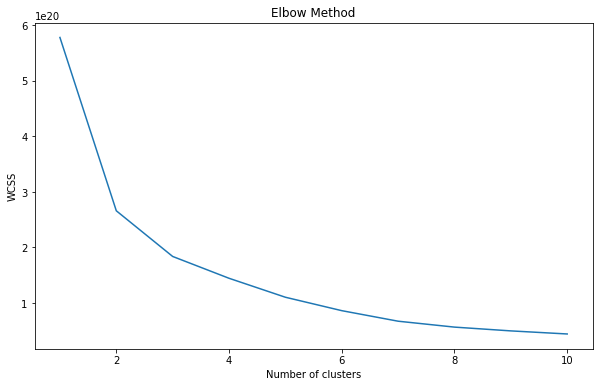

In [306]:
# checking the best number of clusters based on content of unwatched movie

plt.figure(figsize = (10,6))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(user_not_watched.drop('movie_title', axis = 1))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [311]:
# choose 6 clusters

kmeans = KMeans(n_clusters=6, max_iter=600, algorithm = 'auto')
kmeans.fit(user_not_watched.drop('movie_title', axis = 1))
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(6)
user_not_watched['cluster'] = pd.DataFrame(lut[kmeans.labels_])
user_not_watched.dropna(axis = 0,inplace = True)
user_not_watched['cluster'] = user_not_watched['cluster'].astype(int)

In [327]:
# fitting the clustering to the movie watched by userId and get all movie in the unwatched movie which match with the cluster

to_recommend = user_not_watched[user_not_watched['cluster'] == kmeans.predict(user_movie_mean)[0]]

In [342]:
# choosing only 5 movies with closest Euclidian Distance to user_movie_mean

def Euclidean_Dist(to_recommend, user_movie_mean, cols=[col for col in to_recommend.columns if col not in ['cluster','movie_title']]):
    return np.linalg.norm(to_recommend[cols].values - user_movie_mean[cols].values,
                   axis=1)
to_recommend['dist'] = Euclidean_Dist(to_recommend, pd.concat([user_movie_mean]*len(to_recommend), ignore_index = True))

for x in list(to_recommend.sort_values(by = 'dist')['movie_title'].unique()[0:5]) :
    print(x)

Lethal Weapon 3
Rambo: First Blood Part II
Gran Torino
Cheaper by the Dozen
21 Jump Street


So we can recommend those 5 movies to userId 1